In [ ]:
# Exploring TACO category names, to decide CLASS_MAP and target classes.

In [73]:
from pathlib import Path
import json
import collections
from collections import Counter
import pandas as pd
import os
import re
import random, cv2
import matplotlib.pyplot as plt
import json
import re
import shutil

In [53]:
%matplotlib inline

In [54]:
print(os.getcwd())

C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\notebooks


In [55]:
ANN_PATH = Path("../data/raw/taco/annotations.json")
IMG_DIR = Path("../data/raw/taco/images")

In [56]:
coco = json.loads(ANN_PATH.read_text())
id_to_img = {im["id"]: im for im in coco["images"]}
id_to_cat = {c["id"]: c["name"] for c in coco["categories"]}

In [57]:
cat_counts = Counter(id_to_cat[a["category_id"]] for a in coco["annotations"])
df_cats = (pd.DataFrame({"category": list(cat_counts.keys()), "count": list(cat_counts.values())})
           .sort_values("count", ascending=False)
           .reset_index(drop=True))
df_cats.head(25) 

,category,count
0,Cigarette,667
1,Unlabeled litter,517
2,Plastic film,451
3,Clear plastic bottle,285
4,Other plastic,273
5,Other plastic wrapper,260
6,Drink can,229
7,Plastic bottle cap,209
8,Plastic straw,157
9,Broken glass,138


Unique categories: 59


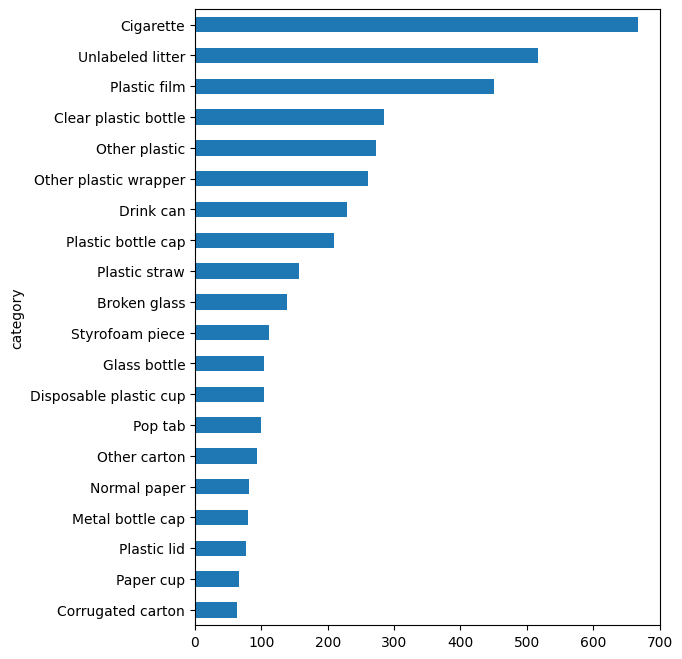

In [58]:
print("Unique categories:", df_cats.shape[0])
ax = df_cats.head(20).plot(kind="barh", x="category", y="count", figsize=(6,8), legend=False)
ax.invert_yaxis()

In [59]:
TARGET_NAMES = ["plastic_bottle", "glass_bottle", "metal_can"]

def norm(s): 
    return re.sub(r"\s+", " ", s.strip().lower())

EXPLICIT = {
    # bottles
    "clear plastic bottle": "plastic_bottle",
    "other plastic bottle": "plastic_bottle",
    "glass bottle": "glass_bottle",
    # cans
    "drink can": "metal_can",
    "food can": "metal_can",
    "tin can": "metal_can",
    "beverage can": "metal_can",
    # explicitly drop small/ambiguous items
    "plastic bottle cap": None,
    "metal bottle cap": None,
    "pop tab": None,
    "broken glass": None,
    "aluminium foil": None,
    "unlabeled litter": None,
    "cigarette": None,
}

BOTTLE_KWS = ["bottle"]
GLASS_KWS  = ["glass"]
PLASTIC_KWS= ["plastic"]
CAN_KWS    = ["can", "tin can", "beverage can", "soda can", "food can"]

def map_category(cat_name: str):
    c = norm(cat_name)
    if c in EXPLICIT:
        return EXPLICIT[c]

    # bottle fallback
    if any(k in c for k in BOTTLE_KWS):
        if any(k in c for k in GLASS_KWS):
            return "glass_bottle"
        if any(k in c for k in PLASTIC_KWS):
            return "plastic_bottle"
        return "plastic_bottle"

    # can fallback → metal_can
    if any(k in c for k in CAN_KWS):
        return "metal_can"

    return None

# rebuild class_map.json (ensure path points to repo-root/data/scripts)
final_map = {}
for cat in coco["categories"]:
    final_map[cat["name"]] = map_category(cat["name"])

out_path = Path("../data/scripts") if Path("notebooks").exists() else Path("data/scripts")
out_path.mkdir(parents=True, exist_ok=True)
(out_path / "class_map.json").write_text(json.dumps(final_map, indent=2))
print("Wrote:", (out_path/"class_map.json").resolve())


Wrote: C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\notebooks\data\scripts\class_map.json


In [60]:
# check
mapped = [map_category(id_to_cat[a["category_id"]]) for a in coco["annotations"]]
pd.Series([m for m in mapped if m is not None]).value_counts()

plastic_bottle    335
metal_can         263
glass_bottle      104
Name: count, dtype: int64

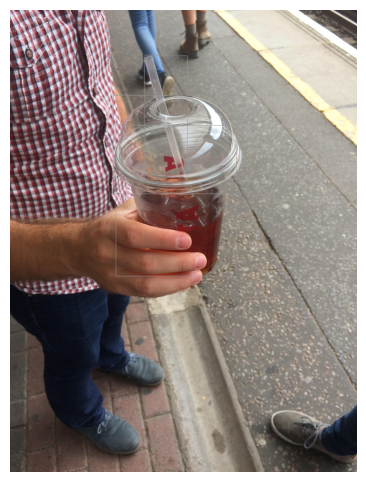

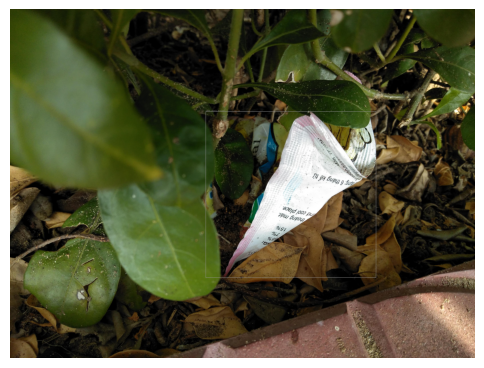

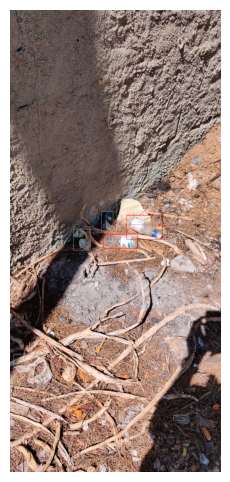

In [66]:
# check
anns_by_img = {}
for ann in coco["annotations"]:
    anns_by_img.setdefault(ann["image_id"], []).append(ann)

def show_random(n=3):
    keys = random.sample(list(anns_by_img.keys()), n)
    for k in keys:
        im = id_to_img[k]
        img_path = IMG_DIR / im["file_name"]
        img = cv2.imread(str(img_path))
        if img is None: 
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        for ann in anns_by_img[k]:
            x,y,bw,bh = ann["bbox"]
            x2,y2 = x+bw, y+bh
            cat_name = id_to_cat[ann["category_id"]]
            mapped   = map_category(cat_name)
            color = (255, 0, 0) if mapped else (150,150,150)
            cv2.rectangle(img, (int(x),int(y)), (int(x2),int(y2)), color, 2)
            label = f"{cat_name} -> {mapped}" if mapped else cat_name
            cv2.putText(img, label[:40], (int(x), max(12,int(y)-4)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis("off"); plt.show()

show_random(3)


In [62]:
# sanity check
valid_image_ids = []

for k, im in id_to_img.items():
    img_path = IMG_DIR / im["file_name"]
    if img_path.exists():
        valid_image_ids.append(k)

print(f"Found {len(valid_image_ids)} valid images with existing files.")



Found 1500 valid images with existing files.


In [63]:
# sanity check
missing = []
for k, im in id_to_img.items():
    img_path = IMG_DIR / im["file_name"]
    if not img_path.exists():
        missing.append(img_path)
        
print(f"{len(missing)} images missing out of {len(id_to_img)}")


0 images missing out of 1500


In [64]:
# build class_map.json
final_map = {}
for c in coco["categories"]:
    final_map[c["name"]] = map_category(c["name"])

Path("../data/scripts").mkdir(parents=True, exist_ok=True)  # .. if running inside notebooks/
map_path = Path("../data/scripts/class_map.json")
map_path.write_text(json.dumps(final_map, indent=2))
print("Wrote:", map_path.resolve())


Wrote: C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\scripts\class_map.json


In [72]:
# after downloading the drinking waste datset (Images_of _waste folder with only the YOLO_imgs folder) 
# directly from the kaggle website to the raw/ folder
# run the following commmands

In [79]:
# ONLY RUN if no labels/ and images/ folders are populated for the drinking waste dataset
# --- Resolve paths from project root reliably ---
NB_DIR = Path().resolve()
PROJECT_ROOT = NB_DIR.parent                                     # Recycling-YOLO/
MIXED_DIR = (PROJECT_ROOT / "data/raw/Images_of_waste/YOLO_imgs").resolve()
TARGET_IMAGES = (PROJECT_ROOT / "data/raw/Images_of_waste/images").resolve()
TARGET_LABELS = (PROJECT_ROOT / "data/raw/Images_of_waste/labels").resolve()

IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
DO_MOVE = True   # <--- set to True to actually move files

print("Mixed dir:", MIXED_DIR)
print("Exists?  ", MIXED_DIR.exists(), " Is dir? ", MIXED_DIR.is_dir())

# --- Sanity: show a few files present ---
if MIXED_DIR.exists():
    sample = list(MIXED_DIR.glob("*"))[:10]
    print("Sample entries in mixed dir:", [p.name for p in sample])

# --- Create targets ---
TARGET_IMAGES.mkdir(parents=True, exist_ok=True)
TARGET_LABELS.mkdir(parents=True, exist_ok=True)

# --- Collect files (recursive, handles nested dirs) ---
imgs = [p for p in MIXED_DIR.rglob("*") if p.is_file() and p.suffix.lower() in IMAGE_EXTS]
txts = [p for p in MIXED_DIR.rglob("*.txt") if p.is_file()]

# Map by stem
img_by_stem = {p.stem: p for p in imgs}
txt_by_stem = {p.stem: p for p in txts}

paired = sorted(set(img_by_stem).intersection(txt_by_stem))
orphan_imgs = sorted(set(img_by_stem).difference(txt_by_stem))
orphan_txts = sorted(set(txt_by_stem).difference(img_by_stem))

print(f"\nFound images: {len(imgs)}, labels: {len(txts)}")
print(f"Paired: {len(paired)}")
print(f"Orphan images (no .txt): {len(orphan_imgs)}")
print(f"Orphan labels (no image): {len(orphan_txts)}")

# --- Move paired files ---
moved = 0
for stem in paired:
    src_img = img_by_stem[stem]
    src_txt = txt_by_stem[stem]
    dst_img = TARGET_IMAGES / src_img.name
    dst_txt = TARGET_LABELS / (stem + ".txt")

    if DO_MOVE:
        # Ensure target dirs exist (already created above, but safe)
        dst_img.parent.mkdir(parents=True, exist_ok=True)
        dst_txt.parent.mkdir(parents=True, exist_ok=True)
        shutil.move(str(src_img), str(dst_img))
        shutil.move(str(src_txt), str(dst_txt))
    else:
        print(f"[DRY-RUN] would move: {src_img} -> {dst_img}")
        print(f"[DRY-RUN] would move: {src_txt} -> {dst_txt}")
    moved += 1

print(("\nMoved" if DO_MOVE else "\nReady to move") + f" {moved} image/label pairs.")


Mixed dir: C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\raw\Images_of_Waste\YOLO_imgs
Exists?   False  Is dir?  False

Found images: 0, labels: 0
Paired: 0
Orphan images (no .txt): 0
Orphan labels (no image): 0

Moved 0 image/label pairs.


In [ ]:
# create donor_names.txt in the Images_of_waste/ folder and populate with the following
# AluCan - aluminium_cans
# Glass - glass_bottles
# PET - plastic_bottles
# HDPEM - HDPE_milk_bottles

Class names: ['AluCan', 'Glass', 'PET', 'HDPEM']


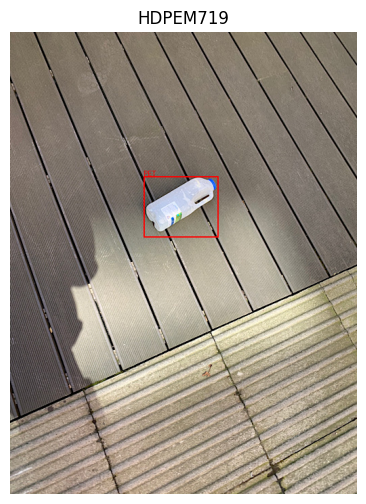

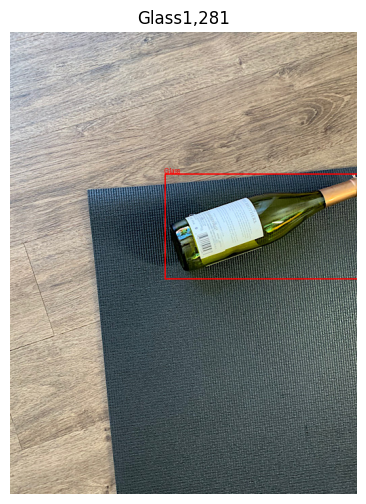

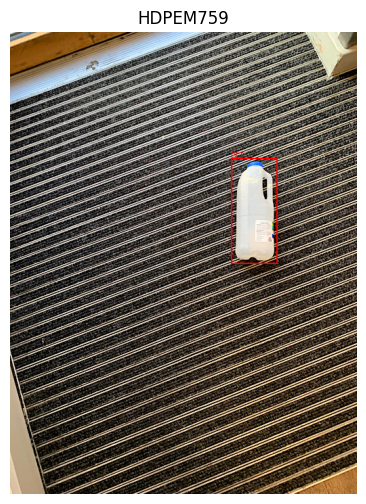

In [98]:

import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Paths
ROOT = Path("../data/raw/Images_of_waste")
IMG_DIR = ROOT / "images"
LABEL_DIR = ROOT / "labels"
NAMES_FILE = ROOT / "donor_names.txt"

# Read class names from donor_names.txt (one name per line)
class_names = [line.strip().split()[0] for line in NAMES_FILE.read_text().splitlines()]
print("Class names:", class_names)

def show_random_samples(n=3):
    label_files = list(LABEL_DIR.rglob("*.txt"))
    if not label_files:
        print("No label files found!")
        return
    for lbl_path in random.sample(label_files, min(n, len(label_files))):
        img_path = IMG_DIR / (lbl_path.stem + ".jpg")
        if not img_path.exists():
            # try other common extensions
            exts = [".png", ".jpeg"]
            for e in exts:
                alt = IMG_DIR / (lbl_path.stem + e)
                if alt.exists():
                    img_path = alt
                    break
        if not img_path.exists():
            print("Missing image for", lbl_path.stem)
            continue

        # open image and prepare to draw
        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        w, h = img.size

        # read YOLO labels
        for line in lbl_path.read_text().splitlines():
            parts = line.split()
            if len(parts) < 5: 
                continue
            cls, x_c, y_c, bw, bh = map(float, parts[:5])
            cls = int(cls)
            x_c, y_c, bw, bh = x_c * w, y_c * h, bw * w, bh * h
            x1, y1 = x_c - bw / 2, y_c - bh / 2
            x2, y2 = x_c + bw / 2, y_c + bh / 2

            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            name = class_names[cls] if cls < len(class_names) else str(cls)
            draw.text((x1, y1 - 10), name, fill="red")

        # display
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(lbl_path.stem)
        plt.show()

# Run the visual check on 3 random images
show_random_samples(3)
